# Estimación de MTF

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

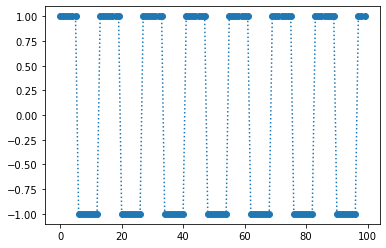

In [2]:
def generar_onda_cuadrada(largo, periodo):
    onda = np.arange(1, largo+1)
    return list(map(lambda x: -1 if (np.mod(x, periodo) >= periodo/2) else 1, onda))
    
plt.plot(generar_onda_cuadrada(largo=100, periodo=14), ':o')

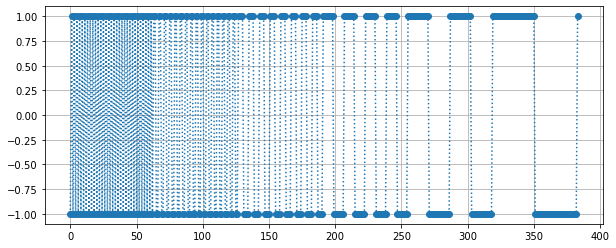

In [3]:
n_rep = 8
largo_max = 10
ys = []

anchos =       [ 2, 4, 8,16,32,64]
repeticiones = [32,16, 8, 4, 2, 1]

for a, r in zip(anchos, repeticiones):
    ys.append(generar_onda_cuadrada(a*r, a))

y = np.hstack(ys)
n_samples = len(y)

t = np.linspace(0, n_samples, n_samples)


n_show = n_samples//10
plt.figure(figsize=(10,4))
plt.grid()
plt.plot(y, ':o')

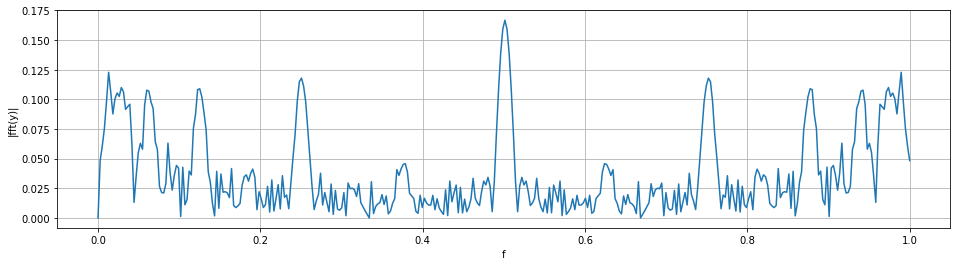

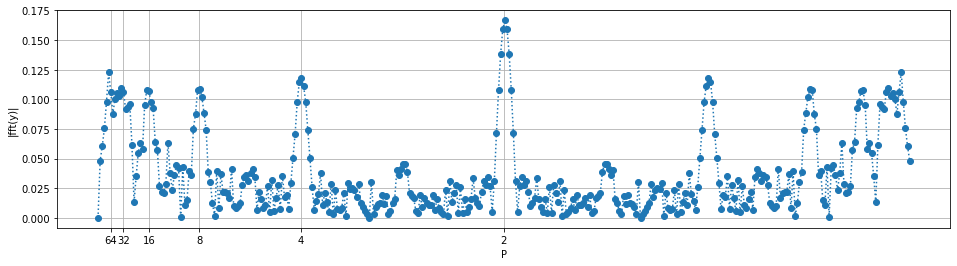

In [4]:
y_f = np.fft.fft(y)

ancho_pantalla = 1920
f = np.linspace(0, 1, n_samples)

plt.figure(figsize=(16,4))
plt.grid()

plt.ylabel('|fft(y)|')
plt.plot(f, np.abs(y_f)/n_samples)
plt.xlabel('f');

x = [1/(a) for a in anchos]
labels = [a for a in anchos]
plt.figure(figsize=(16,4))
plt.ylabel('|fft(y)|')
plt.grid()
n_show = n_samples
plt.plot(f[:n_show], np.abs(y_f[:n_show])/n_samples , ':o')
plt.xticks(x, labels);
plt.xlabel('P');

## 1. Generar patrón

True

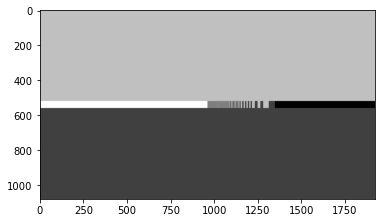

In [5]:
# ajustar según pantalla donde se saca la foto, poner la resolución del monitor

ancho_pantalla = 1920
alto_pantalla = 1080

alto_franja_central_px = 40

oscuro = 64
claro = 192

medio = (claro+oscuro)/2
amplitud = (claro-oscuro)/2

onda = medio + amplitud*y

centro_izq = 255*np.ones((alto_franja_central_px, ancho_pantalla//2))
centro_der =   0*np.ones((alto_franja_central_px, ancho_pantalla//2 - len(onda)))

arriba = claro*np.ones((alto_pantalla//2 - alto_franja_central_px//2, ancho_pantalla))
centro = np.hstack((centro_izq, np.tile(onda, (alto_franja_central_px, 1)), centro_der))
abajo = oscuro*np.ones((alto_pantalla//2 - alto_franja_central_px//2, ancho_pantalla))

patron_mtf = np.vstack((arriba, centro, abajo)).astype(np.uint8)

patron_mtf = cv2.cvtColor(patron_mtf, cv2.COLOR_GRAY2RGB)

plt.imshow(patron_mtf)
cv2.imwrite('patron_mtf.png', patron_mtf)

![title](patron_mtf.png)

## 2. Adquirir patrón

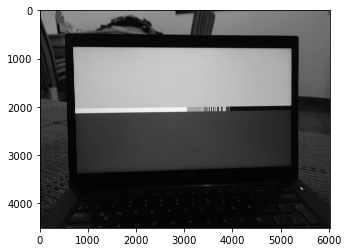

In [6]:
mtf_leer = cv2.imread('mtf.jpg')
mtf_leido_gray = cv2.cvtColor(mtf_leer, cv2.COLOR_BGR2GRAY)
plt.imshow(mtf_leido_gray, cmap='gray')

## 3. Preprocesar muestra

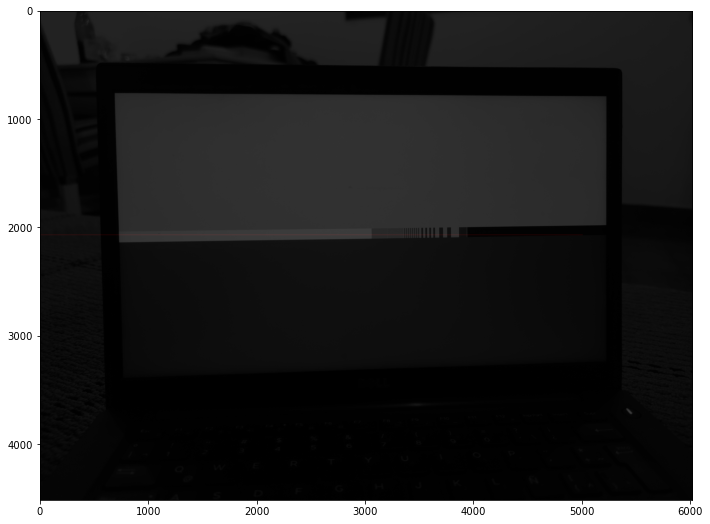

In [7]:
## Buscar de pegarle con un corte a la zona del mtf
ajustar_linea_mtf = cv2.cvtColor(mtf_leido_gray//4, cv2.COLOR_GRAY2RGB)

ancho_foto = mtf_leido_gray.shape[1]

fila_mtf = 2070
zoom = 1600

# rellenar con principio y fin del patrón mtf en la foto:
columnas_mtf = slice(0, 5000)

ajustar_linea_mtf[fila_mtf, columnas_mtf, 0] = 255

plt.figure(figsize=(16,9));
plt.imshow(ajustar_linea_mtf);

In [8]:
# refinamos el corte
zoom = 1000
fila_mtf = 2070

columnas_mtf = slice((ancho_foto//2-zoom//2), (ancho_foto//2+zoom//2))


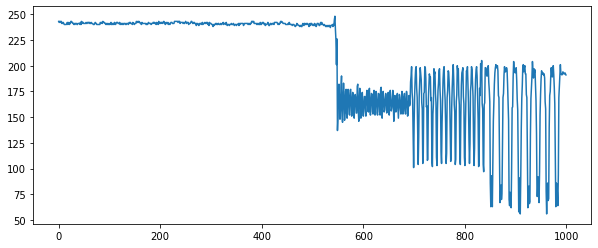

In [9]:
# dibujamos con más detalle el corte

y_est = mtf_leido_gray[fila_mtf, columnas_mtf]

plt.figure(figsize=(10,4))
plt.plot(y_est)

<IPython.core.display.Javascript object>


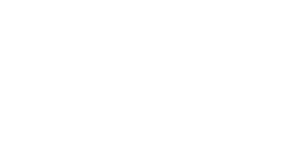

In [10]:
# Generamos gráfico para leer donde cortar para recuperar la estimación de la y de arriba

# por ahí si no quedó perfectamente centrado necesitan otro valor diferente de +/- 35:
claro_est = mtf_leido_gray[fila_mtf-35, columnas_mtf]
oscuro_est = mtf_leido_gray[fila_mtf+35, columnas_mtf]

%matplotlib notebook
plt.figure(figsize=(10,4))
plt.plot(y_est)
plt.plot(claro_est)
plt.plot(oscuro_est)

<IPython.core.display.Javascript object>


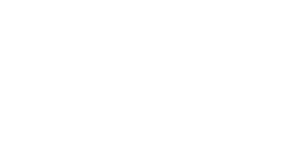

In [11]:
# Leer del gráfico de arriba
k_start = 530
k_end = 1000

y_est_r = y_est[k_start:k_end] 

%matplotlib notebook
plt.figure(figsize=(10,4))
plt.grid()
plt.plot(y_est_r)


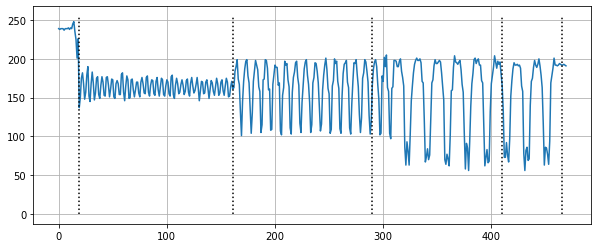

In [12]:
# llenar con bordes medidos del gráfico:
bordes= [19, 161, 290, 410, 465]
         
%matplotlib inline
plt.figure(figsize=(10,4))
plt.grid()
plt.plot(y_est_r)

for b in bordes:
    plt.plot([b, b], [0, 255], ':k')


## 4. Extraer MTF

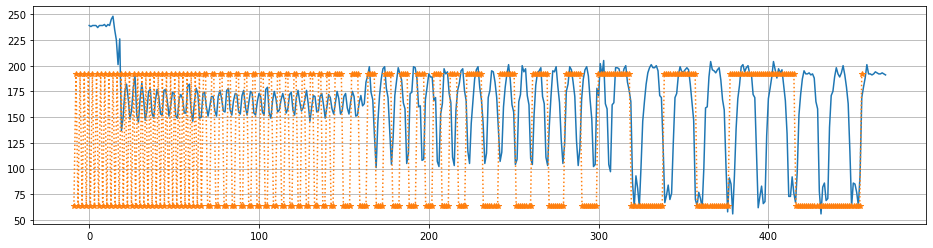

In [13]:
# comparamos con la función que le "metimos de entrada" al sistema
%matplotlib inline
plt.figure(figsize=(16,4))
plt.grid()
plt.plot(y_est_r)

# -9,455 son offsets para que quede bien, cambiarlo según lo que obtuvieron
offset_l = -9
offset_r = 455

x_est=np.linspace(offset_l,offset_r,len(onda))
plt.plot(x_est, onda, ':*')

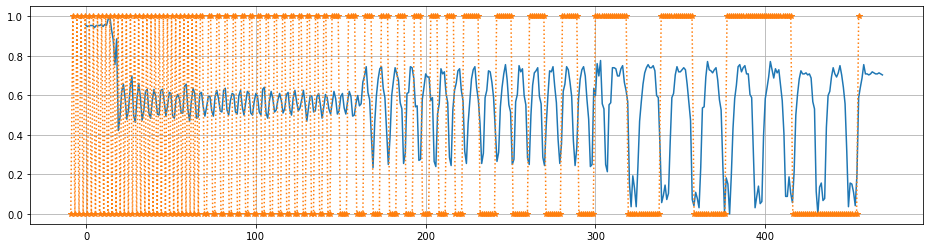

In [14]:
# idem normalizado
%matplotlib inline
plt.figure(figsize=(16,4))
plt.grid()
plt.plot((y_est_r-np.min(y_est_r))/(np.max(y_est_r)-np.min(y_est_r)))
x_est=np.linspace(offset_l,offset_r,len(onda))
plt.plot(x_est, (onda-np.min(onda))/(np.max(onda)-np.min(onda)), ':*')

In [15]:
# Sacar fotos y tomar nota de la geometría de cómo tomaron la foto en particular distancia al monitor 
# y ángulo subtendido por zona usada para calcular mtf:
distancia_monitor_mm = 500
ancho_zona_mtf_mm = 70

# Calcular ángulo que genera la zona usada para medir mtf (cateto menor en la pantalla 
# y cateto mayor distancia entre cámara y pantalla)
angulo_zona_mtf_deg = np.arctan2(ancho_zona_mtf_mm, distancia_monitor_mm)*180/np.pi
ancho_zona_mtf_px = len(y_est_r)

In [16]:
# Calculamos grados por pixel para usar en el gráfico
deg_per_px = ancho_zona_mtf_px/angulo_zona_mtf_deg


0.10467706
0.16207951
0.33112583
0.57088125
0.5642023
0.0052083335


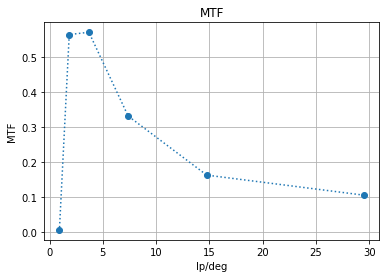

In [17]:
# medimos el contraste en cada tramo y lo graficamos
tramos = np.split(y_est_r, bordes)

mtfs = []

for tramo in tramos:
    i_max = np.max(tramo).astype(np.float32)
    i_min = np.min(tramo).astype(np.float32)
    mtf = (i_max - i_min) / (i_max + i_min)
    mtfs.append(mtf)
    print(mtf)
    
plt.grid(); plt.title('MTF')
plt.plot(1/np.array(anchos)*deg_per_px, mtfs, ':o')
plt.ylabel('MTF');
plt.xlabel('lp/deg');

Del gráfico se puede observar que se obtuvo un **MTF 50 de entre 2 y 5 pares de líneas por grado** lo que es significativamente  mas bajo que el de la clase práctica.